In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import copy

module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [12]:
from pricing.rfsv import RFSV
from pricing.price_engine import MontelCarloOptionPricingEngine

S = 300
r = 0.05
T = 1
params = {
    'mu': r,
    'h2': 0.1,
    'corr': 0.02,

    'x0': np.log(0.15),
    'x_mr': 2,
    'x_mu': np.log(0.15),
    'x_vol': 0.1
}

rfsv = RFSV()
pricer = MontelCarloOptionPricingEngine(rfsv)

implied_vols = pricer.european_call_find_implied_vols(
    S, np.linspace(270, 330, 13), r=r,
    T=T, size=4096, batch_sim_num=10000, batch_num=10,
    **params
)

[45.55119518 41.7120628  38.03268017 34.52948049 31.22359433 28.11479526
 25.19978573 22.48880458 19.9863539  17.69041067 15.58350435 13.67495704
 11.95995902]
[44.95945746 41.1230323  37.44717431 33.95888401 30.66888647 27.58524839
 24.6948373  22.01652243 19.54510302 17.28346439 15.22299564 13.35502922
 11.66399943]
[44.7923668  40.94390154 37.26572546 33.77988434 30.48994029 27.39285686
 24.49934654 21.80802532 19.33126665 17.06422587 14.9982574  13.13168723
 11.45050718]
[44.99822895 41.17919061 37.52991615 34.05576646 30.77333993 27.68516986
 24.78972388 22.0871687  19.59348826 17.30950494 15.23165451 13.346552
 11.65940233]
[45.72344717 41.89672667 38.22774948 34.72788066 31.40280901 28.27082208
 25.34066074 22.61833375 20.11275267 17.8197288  15.73807038 13.85485031
 12.14624474]
[45.4753373  41.62297692 37.93754677 34.42866901 31.10338213 27.96746302
 25.02871855 22.29287691 19.77153374 17.46568351 15.35678515 13.43554236
 11.69381581]
[45.55070405 41.67929381 37.97423855 34.45

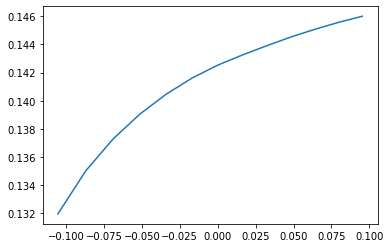

In [14]:
plt.plot(np.log(np.linspace(270, 330, 13) / S), implied_vols)
plt.show()

Calibration

In [45]:
import pandas as pd
import datetime as dt

df = pd.read_csv('../../../data/oxfordmanrealizedvolatilityindices.csv', 
    index_col=0, usecols=[0,1,4])
df = df[df['Symbol'] == '.SPX']
df.index = [dt.datetime.fromisoformat(str(date)).date() for date in df.index.values]
df[df.index >= dt.date(2017,1,1)]

,Symbol,rv5_ss
2017-01-03,.SPX,0.000035
2017-01-04,.SPX,0.000013
2017-01-05,.SPX,0.000012
2017-01-06,.SPX,0.000015
2017-01-09,.SPX,0.000008
...,...,...
2022-06-08,.SPX,0.000107
2022-06-09,.SPX,0.000134
2022-06-10,.SPX,0.000262
2022-06-13,.SPX,0.000230


In [47]:
def dlsig2(sig, x, pr=False):
    if pr:
        a= np.array([(sig-sig.shift(lag)).dropna() for lag in x])
        a=a ** 2
    return [np.mean((sig-sig.shift(lag)).dropna() ** 2) for lag in x]


h_est = list()

sig = df['rv5_ss']
sig = np.log(np.sqrt(sig))
x = np.arange(1, 100)
model = np.polyfit(np.log(x), np.log(dlsig2(sig, x)), 1)
h_est = model[0]/2.
h_est

0.143507819888922

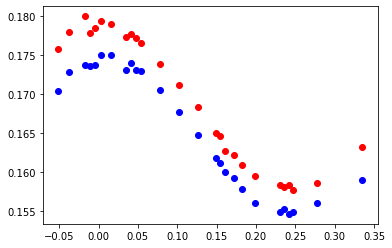

In [57]:
import yfinance as yf
from datetime import date, datetime, timedelta
from pricing.price_engine import find_implied_vol_curve

spx = yf.Ticker("^SPX")

expiry_date = date(2023, 6, 16)
start_date = date(2022, 6, 15)

spx_option_data = spx.option_chain(expiry_date.strftime('%Y-%m-%d')).calls
spx_option_data = spx_option_data[
    (spx_option_data['lastTradeDate'] >= start_date.strftime('%Y-%m-%d')) & 
    (spx_option_data['strike'] > 3000) &
    (spx_option_data['strike'] < 5500)
]
Ks = spx_option_data['strike'].to_numpy()
real_bids = spx_option_data['bid'].to_numpy()
real_asks = spx_option_data['ask'].to_numpy()

r = 0.04791
S0 = spx.history()['Close'][0]
T = (expiry_date - start_date) / timedelta(days=365)

log_Ks = np.log(Ks / S0)
real_bids_implied_vol = find_implied_vol_curve(S0,T,r, Ks, real_bids)
real_asks_implied_vol = find_implied_vol_curve(S0,T,r, Ks, real_asks)

plt.scatter(log_Ks, real_bids_implied_vol, color='blue')
plt.scatter(log_Ks, real_asks_implied_vol, color='red')
plt.show()

In [55]:
v_0 = np.sqrt(df.iloc[-1]['rv5_ss'] * 252)
v_0

0.24197436004346493

In [63]:
np.log(v_0)

-1.4189235086721892

In [76]:
from skopt import gp_minimize, callbacks
from skopt.space import Real
from skopt.utils import use_named_args

dim_corr = Real(name='corr', low=-0.3, high=0.3)
dim_xmr = Real(name='x_mr', low=0.001, high=5)
dim_xmu = Real(name='x_mu', low=-3, high=0)
dim_xvol = Real(name='x_vol', low=0.01, high=1)
dim = [dim_corr, dim_xmr, dim_xmu, dim_xvol]

x0 = (np.log(real_bids_implied_vol[0]) + np.log(real_asks_implied_vol[1])) / 2

params = {
    'mu': r,
    'h2': h_est,
    'corr': 0.02,

    'x0': x0,
    'x_mr': 2,
    'x_mu': x0,
    'x_vol': 0.1
}

pricer = MontelCarloOptionPricingEngine(rfsv)

def rfsv_calibrate_error(corr, x_mr, x_mu, x_vol):
    params['corr'] = corr
    params['x_mr'] = x_mr
    params['x_mu'] = x_mu
    params['x_vol'] = x_vol
    
    curve = pricer.european_call_find_implied_vols(
        S0, Ks, r, T, size=2048, batch_num=10, **params
    )
    diff = (curve - real_bids_implied_vol)**2
    diff += (curve - real_asks_implied_vol)**2
    return np.sum(diff)

@use_named_args(dimensions=dim)
def _rfsv_calibrate_error(corr, x_mr, x_mu, x_vol):
    return rfsv_calibrate_error(corr, x_mr, x_mu, x_vol)

checkpoint_saver = callbacks.CheckpointSaver(
    './CheckpointSaver/rfsv_2023_06_16_2022_06_15_2.pkl', 
    compress=9
)

result = gp_minimize(
    _rfsv_calibrate_error,
    dim,
    x0=[params['corr'], params['x_mr'], params['x_mu'], params['x_vol']],
    callback=[checkpoint_saver],
    verbose=True,
    n_jobs=-1
)

Iteration No: 1 started. Evaluating function at provided point.
Finsihed  100.00%
Iteration No: 1 ended. Evaluation done at provided point.
Time taken: 80.9429
Function value obtained: 0.0060
Current minimum: 0.0060
Iteration No: 2 started. Evaluating function at random point.
Finsihed  100.00%
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 80.7725
Function value obtained: 99649.7278
Current minimum: 0.0060
Iteration No: 3 started. Evaluating function at random point.
Finsihed  100.00%
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 80.3226
Function value obtained: 159438.3338
Current minimum: 0.0060
Iteration No: 4 started. Evaluating function at random point.
Finsihed  100.00%
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 80.3317
Function value obtained: 139508.2673
Current minimum: 0.0060
Iteration No: 5 started. Evaluating function at random point.
Finsihed  100.00%
Iteration No: 5 ended. Evaluation done at random point

In [78]:
opt_result = result.x

In [79]:
opt_result

[0.02, 2, -1.747988821085779, 0.1]

Finsihed  100.00%


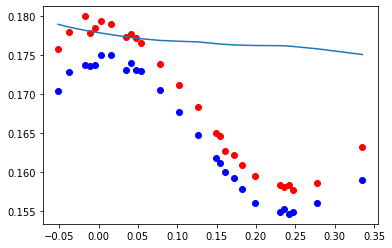

In [85]:
params['corr'] = -opt_result[0]
params['x_mr'] = opt_result[1]
params['x_mu'] = opt_result[2]
params['x_vol'] = opt_result[3]

curve = pricer.european_call_find_implied_vols(
    S0, Ks, r, T, size=4096, batch_num=5, **params
)

plt.plot(log_Ks, curve)
plt.scatter(log_Ks, real_bids_implied_vol, color='blue')
plt.scatter(log_Ks, real_asks_implied_vol, color='red')
plt.show()

Finsihed  100.00%
0.004249515101322972


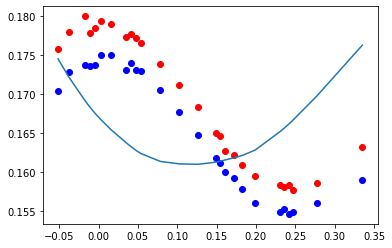

In [130]:
params['h2'] = h_est
params['corr'] = -0.02
params['mu'] = r
params['x0'] = -2
params['x_mr'] = 5e-2
params['x_mu'] = -2
params['x_vol'] = 0.45

curve = pricer.european_call_find_implied_vols(
    S0, Ks, r, T, size=1024, batch_num=1, **params
)

sum_diff = (curve - real_bids_implied_vol)**2
sum_diff += (curve - real_asks_implied_vol)**2
print(np.sum(sum_diff))

plt.plot(log_Ks, curve)
plt.scatter(log_Ks, real_bids_implied_vol, color='blue')
plt.scatter(log_Ks, real_asks_implied_vol, color='red')
plt.show()

In [159]:
h_est

0.143507819888922

RFSV: Simulating  99.99% dwh
Finsihed  100.00%
0.002439333920414208


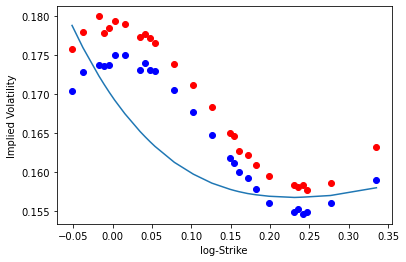

In [158]:
x_est = -1.98
params['h2'] = h_est
params['corr'] = -0.05
params['mu'] = r
params['x0'] = -1.95
params['x_mr'] = 0.0125
params['x_mu'] = -1.87
params['x_vol'] = 0.25

rfsv.simulate(S0, T, 1001, 10000)

curve = pricer.european_call_find_implied_vols(
    S0, Ks, r, T, size=2048, batch_num=10, **params
)

sum_diff = (curve - real_bids_implied_vol)**2
sum_diff += (curve - real_asks_implied_vol)**2
print(np.sum(sum_diff))

plt.plot(log_Ks, curve)
plt.scatter(log_Ks, real_bids_implied_vol, color='blue')
plt.scatter(log_Ks, real_asks_implied_vol, color='red')
plt.xlabel('log-Strike')
plt.ylabel('Implied Volatility')
plt.show()

In [160]:
T

1.0027397260273974

In [82]:
rfsv_calibrate_error(-opt_result[0], opt_result[1], opt_result[2], opt_result[3])

Finsihed  100.00%


0.009806305237992464

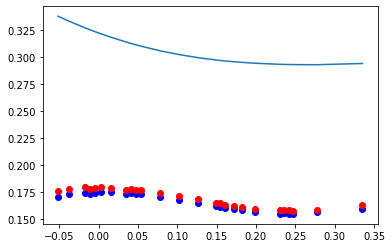

In [84]:
plt.scatter(log_Ks, real_bids_implied_vol, color='blue')
plt.scatter(log_Ks, real_asks_implied_vol, color='red')
plt.plot(log_Ks, curve)
plt.show()

In [161]:
params

{'mu': 0.04791,
 'h2': 0.143507819888922,
 'corr': -0.05,
 'x0': -1.95,
 'x_mr': 0.0125,
 'x_mu': -1.87,
 'x_vol': 0.25}

In [162]:
S0

3789.989990234375

RFSV: Simulating  99.99% dwh
Finsihed  100.00%
0.031400780566288915


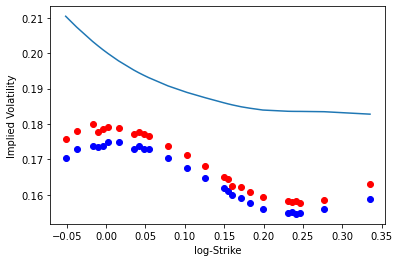

In [179]:
x_est = -1.98
params['h2'] = h_est
params['corr'] = -0.05
params['mu'] = r
params['x0'] = -1.79
params['x_mr'] = 0.0125
params['x_mu'] = -3
params['x_vol'] = 0.25

rfsv.simulate(S0, T, 1001, 10000)

curve = pricer.european_call_find_implied_vols(
    S0, Ks, r, T, size=2048, batch_num=1, **params
)

sum_diff = (curve - real_bids_implied_vol)**2
sum_diff += (curve - real_asks_implied_vol)**2
print(np.sum(sum_diff))

plt.plot(log_Ks, curve)
plt.scatter(log_Ks, real_bids_implied_vol, color='blue')
plt.scatter(log_Ks, real_asks_implied_vol, color='red')
plt.xlabel('log-Strike')
plt.ylabel('Implied Volatility')
plt.show()

In [168]:
np.average(np.array([real_asks_implied_vol, real_bids_implied_vol]))

0.16729963814466722

In [180]:
(Ks,real_asks, real_bids)

(array([3600., 3650., 3725., 3750., 3775., 3800., 3850., 3925., 3950.,
        3975., 4000., 4100., 4200., 4300., 4400., 4425., 4450., 4500.,
        4550., 4625., 4775., 4800., 4825., 4850., 5000., 5300.]),
 array([471.8, 442.8, 400.4, 383.1, 370.1, 357.6, 330.9, 291.5, 280.5,
        268.5, 256.7, 212.2, 173. , 138.6, 108.7, 102.4,  94.6,  84. ,
         73.5,  60.1,  40.5,  37.7,  35.6,  32.8,  22.5,  11.3]),
 array([465.3, 436.2, 391.9, 377.2, 363.4, 351.4, 325. , 285.2, 274.9,
        262.3, 251.3, 207.2, 167.9, 133.6, 104.5,  98.1,  91.3,  80.5,
         70. ,  56.6,  37.6,  35.5,  32.7,  30.7,  21. ,   9.8]))

In [181]:
from fbm.utils import BackupHelper

spx_data_backup = BackupHelper('./data', 'spx_data_0616')
spx_data_backup.dump((Ks, real_asks, real_bids))